In [631]:
from datetime import date
import tearsheet as ts
import ankitfinance as af
import fundamental_health_topis as tp
import talib
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR



In [1563]:
data=pd.read_csv("D:Msc-Finance/var_model/data.csv",parse_dates=True,header=0)
r=pd.DataFrame(pd.date_range(start='1959',end='2010',freq='Q')).iloc[:-1]
data.index=r.iloc[:,0]
data=data.drop(labels=['year','quarter'],axis=1)

In [1564]:
# Granger Test

In [1565]:
x=len(data.columns)
f=len(data.columns)
c=pd.DataFrame()
d=pd.DataFrame()

In [1566]:
for i in range(x):
    ini_x=i
    x=data.iloc[:,ini_x]
    for y in range(f):
        ini_y=y
        Y=data.iloc[:,ini_y]
        frame=pd.DataFrame(data=[x,Y]).T
        test=pd.Series(grangercausalitytests(frame,maxlag=12,verbose=False)[1][0]['ssr_chi2test'][1])
        c=c.append(test,ignore_index=True)
    c.columns=[x.name+'_X']
    c.index=data.columns
    d=d.append(c.T)
    c=pd.DataFrame()

In [1567]:
def color_p_red(val):
    color = 'red' if val < 0.05 else 'black'
    return 'color: %s' % color

## Granger Casuality Test

In [1568]:
d.style.applymap(color_p_red)

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
realgdp_X,0.999999,0.664649,0.092534,0.042273,0.830586,0.273713,0.078000,0.232959,0.509500,0.019395,0.200552,0.768670
realcons_X,0.009486,1.000000,0.000162,0.026466,0.081570,0.194942,0.053550,0.089805,0.484897,0.003365,0.000012,0.000595
realinv_X,0.385111,0.307447,1.000000,0.034430,0.338712,0.895584,0.567637,0.746549,0.419314,0.684394,0.213527,0.062225
realgovt_X,0.114945,0.071108,0.128299,1.000000,0.069489,0.114428,0.629148,0.853003,0.213576,0.223582,0.731229,0.782338
realdpi_X,0.000332,0.006231,0.053801,0.303653,1.000000,0.310651,0.280910,0.451991,0.922392,0.009890,0.001479,0.002340
cpi_X,0.360925,0.557115,0.921588,0.071047,0.203763,0.999999,0.016045,0.000000,0.245879,0.001502,0.000000,0.259148
m1_X,0.616960,0.392818,0.004301,0.000001,0.149487,0.010446,1.000000,0.188894,0.000003,0.154972,0.548222,0.557801
tbilrate_X,0.108478,0.100233,0.159520,0.059193,0.098521,0.076562,0.114648,1.000000,0.847360,0.130213,0.346610,0.338903
unemp_X,0.148509,0.138792,0.406066,0.124878,0.124277,0.182853,0.291186,0.162323,1.000000,0.161667,0.073236,0.533672
pop_X,0.138439,0.611256,0.919374,0.942987,0.650256,0.000000,0.000000,0.000102,0.068981,0.999998,0.001830,0.811830


In [1569]:
# Selecting Real interest Rate (Last Row) for prediction

In [1594]:
fair_data=data[d[d<0.05].iloc[-1].dropna().index]

In [1595]:
# Cointegration Test

In [1596]:
l=coint_johansen(fair_data,det_order=1, k_ar_diff=5)

In [1597]:
j=pd.concat([pd.DataFrame(l.lr1),pd.DataFrame(l.cvt).iloc[:,1]],axis=1)

In [1598]:
j.columns=['Test Statistic', 'C(95%)']
j['Result']=np.where(j.iloc[:,0]>j.iloc[:,1],'True','False')

In [1599]:
j.index=fair_data.columns

## Co-integration Test

In [1600]:
j

,Test Statistic,C(95%),Result
tbilrate,24.865326,18.3985,True
infl,11.383613,3.8415,True


In [1601]:
# First Difference to make series stationary # DickerFuller Test

In [1602]:
dif=fair_data.diff().dropna()
#dif=dif.diff().dropna()

In [1603]:
# Testing and Training

In [1604]:
lag=5 # AIC value

In [1605]:
train=dif.iloc[:-lag]
test=dif.iloc[-lag:]

In [1606]:
model=VAR(train)

In [1607]:
result=model.fit(lag)

## VAR summary

In [1608]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, Mar, 2022
Time:                     23:22:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.38430
Nobs:                     192.000    HQIC:                   1.16221
Log likelihood:          -619.932    FPE:                    2.74916
AIC:                      1.01104    Det(Omega_mle):         2.45929
--------------------------------------------------------------------
Results for equation tbilrate
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.006803         0.059728           -0.114           0.909
L1.tbilrate         0.152845         0.076228            2.005           0.045
L1.infl            -0.026251         0.032972           -0.796   

In [1609]:
lag_order = result.k_ar
print(lag_order)  


5


In [1610]:
# Input data for forecasting
forecast_input = train.values[-lag_order:]
forecast_input

array([[-0.23, -1.83],
       [-0.72,  0.7 ],
       [-0.99,  2.93],
       [-1.45, -3.56],
       [ 0.18,  5.71]])

In [1611]:
fc = result.forecast(y=forecast_input, steps=lag)


In [1612]:
fored=pd.DataFrame(fc,index=test.index,columns=train.columns+'_1d')

In [1613]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [1614]:
df_results = invert_transformation(train, fored, second_diff=False)

In [1615]:
df_results

,tbilrate_1d,infl_1d,tbilrate_forecast,infl_forecast
0,,,,
2008-09-30,0.286698,-2.448195,0.466698,3.261805
2008-12-31,-0.222019,0.061122,0.244679,3.322927
2009-03-31,0.058636,1.065261,0.303315,4.388188
2009-06-30,-0.052476,-0.784200,0.250839,3.603989
2009-09-30,-0.366598,0.014626,-0.115759,3.618615


In [1616]:
test

,tbilrate,infl
0,,
2008-09-30,-0.57,-11.69
2008-12-31,-1.05,-5.63
2009-03-31,0.10,9.73
2009-06-30,-0.04,2.43
2009-09-30,-0.06,0.19


In [1619]:
h=pd.concat([test.iloc[:,0],df_results.iloc[:,2]],axis=1)

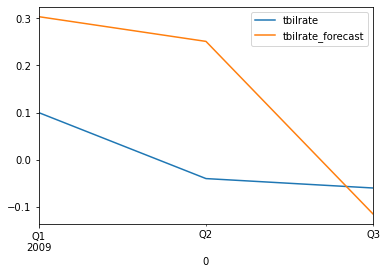

In [1624]:
h.iloc[2:].plot()

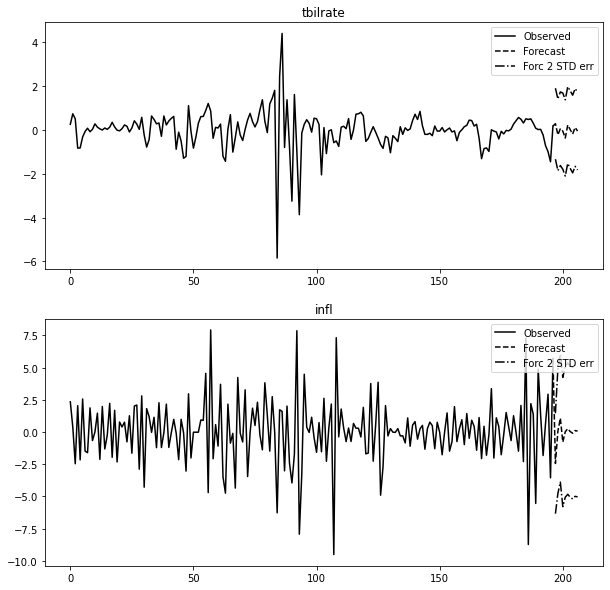

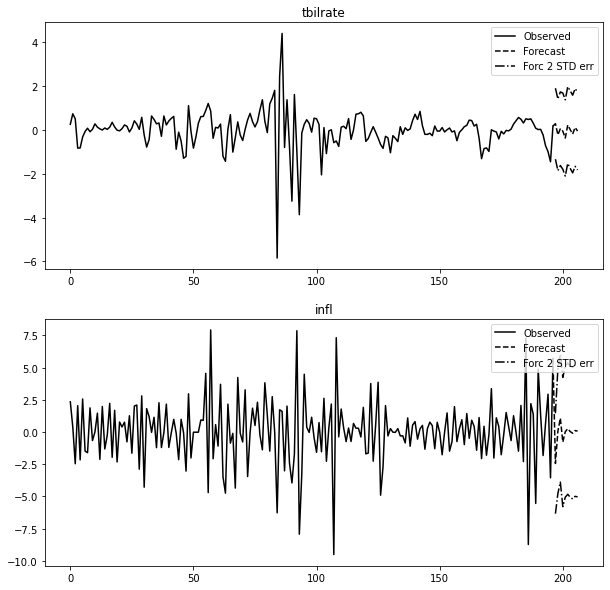

In [1618]:
result.plot_forecast(10)
